<a href="https://colab.research.google.com/github/wiwekapremana/system-recommendation/blob/main/Proyek_Akhir_MLT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nama : Komang Wiweka Premana
## Dataset : https://www.kaggle.com/CooperUnion/anime-recommendations-database

# Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import re
%matplotlib inline
import seaborn as sns
from google.colab import files
from collections import defaultdict
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
import warnings
warnings.filterwarnings('ignore')

print('tensorflow version:', tf.__version__)

tensorflow version: 2.7.0


# Import Data

In [ ]:
! pip install -q kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wiwekapremana","key":"ced7b6390c8252c02cfd38cad8614014"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!kaggle datasets download -d CooperUnion/anime-recommendations-database
!unzip /content/anime-recommendations-database.zip

kaggle.json
 68% 17.0M/25.0M [00:00<00:00, 12.0MB/s]
100% 25.0M/25.0M [00:01<00:00, 25.8MB/s]
Archive:  /content/anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


# Data Understanding

Pada Proyek akhir ini saya menggunakan dataset yang saya temukan di kaggel, dimana pada proyek akhir ini saya menggunakan dataset [Anime Recommendations Database](https://www.kaggle.com/CooperUnion/anime-recommendations-database). Pada Dataset ini terdapat beberapa variable atau kolom yang dapat dilihat sebagai berikut: 

**Anime.csv**<br>
* anime_id - sebuah unique id pada myanimelits.net untuk mengidentifikasi sebuah anime.
* name - judul pada sebuah anime.
* genre - daftar genre yang dipisahkan dengan koma.
* type - movie, TV, OVA, etc.
* episodes - episode yang tersedia pada anime tertentu. (1 eps jika bertipe movie).
* rating - rata-rata rating yang diberikan.
* members - jumlah anggota komunitas yang ada di anime ini
"group".<br>

**Rating.csv**<br>
* user_id - user id yang dibuat secara acak dan tidak terdefinisi.
* anime_id - anime yang telah di rating oleh pengguna.
* rating - rating yang diberikan pengguna dari 10 (-1 apabila user hanya menontonnya saja tetapi tidak memberikan rating pada anime tersebut).

In [ ]:
anime_data = pd.read_csv('/content/anime.csv')
anime_data

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [ ]:
rating_df = pd.read_csv('/content/rating.csv')
rating_df

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [ ]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [ ]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [ ]:
rating_df.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [ ]:
print("Jumlah total seluruh anime : {}".format(len(anime_data.anime_id .unique())))
print("Jumlah total seluruh rating : {}".format(len(rating_df.user_id.unique())))

Jumlah total seluruh anime : 12294
Jumlah total seluruh rating : 73515


## Membersihkan data yang kosong

In [ ]:
null_features = anime_data.columns[anime_data.isna().any()]
anime_data[null_features].isna().sum()

genre      62
type       25
rating    230
dtype: int64

In [ ]:
anime_data.isnull().sum()/len(anime_data)*100

anime_id    0.000000
name        0.000000
genre       0.504311
type        0.203351
episodes    0.000000
rating      1.870831
members     0.000000
dtype: float64

In [ ]:
anime_data.dropna(inplace=True)

# Visualisasi Data

## Text Cleaning

langkah selanjutnya adalah melakukan text cleaning karena Pada data ini terdapat beberapa anime yang memiliki judul dengan menggunakan huruf jepang atau karakter khusus. 

In [ ]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

anime_data['name'] = anime_data['name'].apply(text_cleaning)

## Menampilkan Jumlah anime berdasarkan Media Streaming

In [ ]:
labels = anime_data['type'].value_counts().index
values = anime_data['type'].value_counts().values
colors = ['red', 'blue', 'darkorange', 'green']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
    title={
        'text': "Type Media Streaming",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Pada diagram diatas dapat disimpulkan bahwa tipe media streaming yang paling banyak adalah media streaming 'TV' dengan total keseluruhan sebanyak 3668

## Menampilkan data genre pada dataset

In [ ]:
all_genre = defaultdict(int)

for genre in anime_data['genre']:
    for genre in genre.split(','):
        all_genre[genre.strip()] += 1

(-0.5, 799.5, 399.5, -0.5)

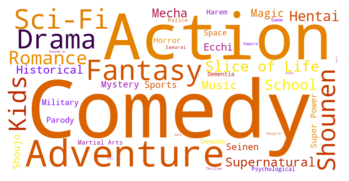

In [ ]:
nonull_anime=anime_data.copy()
nonull_anime.dropna(inplace=True)

all_genres = defaultdict(int)

for genres in nonull_anime['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1
        
genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')

Pada gambar diatas dapat dilihat bahwa anime yang memiliki genre 'Comedy' dan 'Action' merupakan anime yang paling banyak atau paling sering muncul

## Menampilkan Anime dengan rating tertinggi berdasarkan type

In [ ]:
anime_data[['name', 'rating', 'type', 'members']].sort_values(by='rating', ascending=False).query('members>500000')[:10]

,name,rating,type,members
1,Fullmetal Alchemist: Brotherhood,9.26,TV,793665
3,Steins;Gate,9.17,TV,673572
13,Code Geass: Hangyaku no Lelouch R2,8.98,TV,572888
19,Code Geass: Hangyaku no Lelouch,8.83,TV,715151
23,One Punch Man,8.82,TV,552458
29,Tengen Toppa Gurren Lagann,8.78,TV,562962
40,Death Note,8.71,TV,1013917
74,One Piece,8.58,TV,504862
86,Shingeki no Kyojin,8.54,TV,896229
98,Psycho-Pass,8.50,TV,509109


Pada data diatas saya menampilkan 10 data anime yang memiliki rating tertinggi dan kebetulan tipe media streaming 'TV'merupaka type dengan rating tertinggi dan member komunitas diatas 500000  

In [ ]:
anime_data[anime_data['type'] == 'OVA'][['name', 'rating', 'type', 'members']].sort_values(by='rating', ascending=False).query('members>100000')[:10]

,name,rating,type,members
21,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,8.83,OVA,129307
66,Hellsing Ultimate,8.59,OVA,297454
245,Detroit Metal City,8.26,OVA,104893
359,Black Lagoon: Robertas Blood Trail,8.15,OVA,108099
456,FLCL,8.06,OVA,305165
468,Golden Boy,8.05,OVA,113040
698,Noragami OVA,7.89,OVA,104775
717,Shingeki no Kyojin OVA,7.88,OVA,121063
1039,Mirai Nikki Redial,7.71,OVA,135604
1536,Mirai Nikki,7.51,OVA,114217


Pada data diatas saya menampilkan 10 data anime yang memiliki tipe media streaming 'OVA' dengan rating tertinggi dan member atau anggota komunitas diatas 100000  

In [ ]:
anime_data[anime_data['type'] == 'Movie'][['name', 'rating', 'type', 'members']].sort_values(by='rating', ascending=False).query('members>200000')[:10]

,name,rating,type,members
0,Kimi no Na wa.,9.37,Movie,200630
15,Sen to Chihiro no Kamikakushi,8.93,Movie,466254
18,Ookami Kodomo no Ame to Yuki,8.84,Movie,226193
25,Suzumiya Haruhi no Shoushitsu,8.81,Movie,240297
24,Mononoke Hime,8.81,Movie,339556
35,Howl no Ugoku Shiro,8.74,Movie,333186
115,Tonari no Totoro,8.48,Movie,271484
130,Neon Genesis Evangelion: The End of Evangelion,8.45,Movie,215630
132,Toki wo Kakeru Shoujo,8.44,Movie,289206
191,Ghost in the Shell,8.34,Movie,223036


Pada data diatas saya menampilkan 10 data anime yang memiliki tipe media streaming 'Movie' dengan rating tertinggi dan member atau anggota komunitas diatas 200000  

# Modeling and Result

## Modelling menggunakan Content-Based Recommendation-System
Pada kasus ini saya melakukan Content-Based Recommendation-System berdasarkan genre dari anime yang terdapat dalam dataset, dengan tahapan sebagai berikut:
1. melakukan pembuatan matrix genre
2. melakukan peembuatan cosine similarity dengan menggunakan matrix genre
3. 10 anime paling mirip berdasarkan skor cosine similarity akan dikembalikan dengan fungsi yang akan dibuat.
4. Dan yang terakhir melakukan uji pada fungsi dengan menuliskan judul anime dan cosine similarity yang digunakan.

In [ ]:
genre_str = anime_data['genre'].str.split(',').astype(str)

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 4), min_df=0)
tfidf_matrix = tfidf.fit_transform(genre_str)

tfidf_matrix.shape

(12017, 5569)

In [ ]:
cosine_sim_genre = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_genre[:4, :4]

array([[1.        , 0.01608551, 0.        , 0.        ],
       [0.01608551, 1.        , 0.01685446, 0.        ],
       [0.        , 0.01685446, 1.        , 0.05595377],
       [0.        , 0.        , 0.05595377, 1.        ]])

In [ ]:
indices = pd.Series(anime_data.index, index=anime_data['name'])

def genre_recommendations(name, cosine_sim):
    
            idx = indices[name]
            sim_scores = (enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[0:11]
        
            anime_indices = [i[0] for i in sim_scores]
            similarity_ = [i[1] for i in sim_scores] 
        
            return pd.DataFrame({'Anime name': anime_data['name'].iloc[anime_indices].values,
                                 'Similarity': similarity_,
                                 'Type': anime_data['type'].iloc[anime_indices].values,
                                 'rating' : anime_data['rating'].iloc[anime_indices].values,
                                 'genre': anime_data['genre'].iloc[anime_indices].values})

In [ ]:
anime_data[anime_data.name.eq('One Punch Man')]

,anime_id,name,genre,type,episodes,rating,members
23,30276,One Punch Man,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,12,8.82,552458


In [ ]:
genre_recommendations('One Punch Man', cosine_sim_genre)

,Anime name,Similarity,Type,rating,genre
0,One Punch Man,1.000000,TV,8.82,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ..."
1,One Punch Man Specials,1.000000,Special,7.86,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ..."
2,One Punch Man: Road to Hero,1.000000,OVA,7.85,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ..."
3,Genji Tsuushin Agedama,0.604524,TV,6.58,"Action, Comedy, Parody, Sci-Fi"
4,Oh! Super Milk-chan,0.604524,TV,6.07,"Action, Comedy, Parody, Sci-Fi"
5,Super Milk-chan,0.604524,TV,5.88,"Action, Comedy, Parody, Sci-Fi"
6,Gungrave,0.536635,TV,7.97,"Action, Drama, Sci-Fi, Seinen, Super Power"
7,Bobobo-bo Bo-bobo Recap,0.535226,Special,6.54,"Action, Comedy, Parody, Sci-Fi, Shounen"
8,Darker than Black: Kuro no Keiyakusha Special,0.483113,Special,7.65,"Comedy, Parody, Sci-Fi"
9,Haiyore! Nyaruko-san W,0.483113,TV,7.43,"Comedy, Parody, Sci-Fi"


Pada table diatas dapat dilihat bahwa terdapat 10 anime yang memiliki similarity(kesamaan) genre yang tinggi pada sebuah anime dengan judul "One Punch Man" dan seluruh anime yang direkomendasikan yang memiliki genre yang relevan dengan anime "One Punch Man"

## Modelling dengan Deep Leaning (Collaborative Filtering)
Disini saya melakukan Collaborative Filtering berdasarkan rating dari anime dari user, berikut tahapannya.
1. Menganalisis data rating.
2. Membuang rating yang tidak digunakan atau diperlukan.
3. Melakukan encoder terhadap 'user_id' dan 'anime_id'
4. Menghitung jumlah 'user_id' dan 'anime_id'
5. Melakukan modelling yang diawali dengan melakukan splitting terhadap data.
6. Membuat fungsi untuk model hingga evaluasi model p
7. Membuat fungsi untuk melakukan prediksi terhadap anime yang akan direkomendasikan kepada pengguna.
8. Menentukan model terbaik dalam memberikan rekomendasi terhadap pengguna.

In [ ]:
rating_df[rating_df['rating'] == -1][['user_id', 'anime_id', 'rating']].sort_values(by='rating', ascending=False)[:10]

,user_id,anime_id,rating
0,1,20,-1
5109801,48797,4382,-1
5109799,48797,2904,-1
5109798,48797,2236,-1
5109797,48797,2167,-1
5109796,48797,2129,-1
5109795,48797,1818,-1
5109794,48797,1691,-1
5109793,48797,1689,-1
5109792,48797,1575,-1


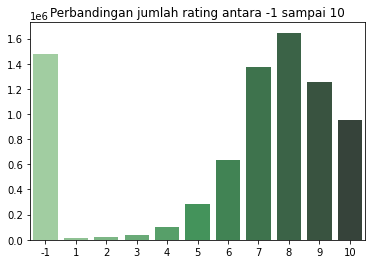

In [ ]:
rating_count = rating_df['rating'].value_counts().sort_index()

sns.barplot(x=rating_count.index,
            y=rating_count.values,
            palette='Greens_d').set_title('Perbandingan jumlah rating antara -1 sampai 10');

Pada diagram diatas dapat disimpulkan terdapat banyak pengguna yang tidak memberi rating. Nilai '-1' berarti pengguna sudah menonton anime tersebut, tetapi tidak memberikan peringkat, jadi saya menghapus rating tersebut.

In [ ]:
mask = (rating_df['rating'] == -1)
rating_df = rating_df.loc[~mask]
len(rating_df)

6337241

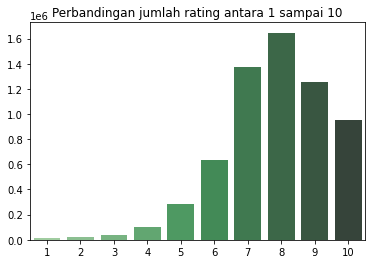

In [ ]:
rating_count = rating_df['rating'].value_counts().sort_index()

sns.barplot(x=rating_count.index,
            y=rating_count.values,
            palette='Greens_d').set_title('Perbandingan jumlah rating antara 1 sampai 10');

In [ ]:
user_enc = LabelEncoder()
rating_df['user_id'] = user_enc.fit_transform(rating_df['user_id'])

anime_enc = LabelEncoder()
rating_df['anime_id'] = anime_enc.fit_transform(rating_df['anime_id'])

In [ ]:
anime_nunique = rating_df['anime_id'].nunique()
userid_nunique = rating_df['user_id'].nunique()

print('Jumlah anime :', anime_nunique)
print('Jumlah penonton :', userid_nunique)

Jumlah anime : 9927
Jumlah penonton : 69600


In [ ]:
rating_df = rating_df[rating_df['user_id'] < 10000]

## Create Model


### Spliting Data


In [ ]:
X = rating_df.drop(['rating'], axis=1)
y = rating_df['rating']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.1,
                                                  stratify=y,
                                                  random_state=2020)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((808262, 2), (89807, 2), (808262,), (89807,))

####Model 1

In [ ]:
def RecommenderV1(n_users, n_animes, n_dim):
    
    # User
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    
    # Anime
    anime = Input(shape=(1,))
    A = Embedding(n_animes, n_dim)(anime)
    A = Flatten()(A)
    
    # Dot U and A
    x = Dot(axes=1)([U, A])
    
    model1 = Model(inputs=[user, anime], outputs=x)
    
    model1.compile(
                  optimizer=Adam(0.0001),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()]
                  )
    model1.summary()
    return model1

In [ ]:
model1 = RecommenderV1(userid_nunique, anime_nunique, 100)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       6960000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       992700      ['input_2[0][0]']                
                                                                                              

In [ ]:
checkpoint1 = ModelCheckpoint('model1.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [ ]:
history1 = model1.fit(x=[X_train['user_id'], X_train['anime_id']],
                    y=y_train,
                    batch_size=64,
                    epochs=15,
                    verbose=1,
                    validation_data=([X_val['user_id'], X_val['anime_id']], y_val),
                    callbacks=[checkpoint1])

Epoch 1/15
12630/12630 [==============================] - 130s 10ms/step - loss: 61.9972 - root_mean_squared_error: 7.8738 - val_loss: 55.9465 - val_root_mean_squared_error: 7.4797
Epoch 2/15
12630/12630 [==============================] - 126s 10ms/step - loss: 35.0288 - root_mean_squared_error: 5.9185 - val_loss: 17.5227 - val_root_mean_squared_error: 4.1860
Epoch 3/15
12630/12630 [==============================] - 125s 10ms/step - loss: 11.0670 - root_mean_squared_error: 3.3267 - val_loss: 7.3677 - val_root_mean_squared_error: 2.7143
Epoch 4/15
12630/12630 [==============================] - 128s 10ms/step - loss: 5.5269 - root_mean_squared_error: 2.3509 - val_loss: 4.5506 - val_root_mean_squared_error: 2.1332
Epoch 5/15
12630/12630 [==============================] - 125s 10ms/step - loss: 3.7416 - root_mean_squared_error: 1.9343 - val_loss: 3.4444 - val_root_mean_squared_error: 1.8559
Epoch 6/15
12630/12630 [==============================] - 125s 10ms/step - loss: 2.9577 - root_mean_

In [ ]:
def make_pred(user_id, anime_id, model):
    return model.predict([np.array([user_id]), np.array([anime_id])])[0][0]

In [ ]:
def get_user_rec(user_id, model):
    
    user_id = int(user_id) - 1
    user_rating = rating_df[rating_df['user_id'] == user_id]
    recommendation = rating_df[~rating_df['anime_id'].isin(user_rating['anime_id'])][['anime_id']].drop_duplicates()
    recommendation['rating_predict'] = recommendation.apply(lambda x: make_pred(user_id, x['anime_id'] , model), axis=1)
    recommendation.loc[:, 'rating_predict'] = recommendation['rating_predict']  -1 
    
    
    final_rec = recommendation.sort_values(by='rating_predict', ascending=False).merge(anime_data[['anime_id', 'name', 'type', 'members']],
                                                                                       on='anime_id').head(10)
    
    return final_rec.sort_values('rating_predict', ascending=False)[['name', 'type', 'rating_predict']]

####Result model 

In [ ]:
get_user_rec(48, model1)

,name,type,rating_predict
0,Koi Hanabi,Music,9.904014
1,Ookami to Koushinryou II Specials,Special,9.649752
2,Astarotte no Omocha!,TV,9.600610
3,Oni Chichi,OVA,9.593935
4,Anime Yasei no Sakebi,TV,9.436468
5,Chicchana Yukitsukai Sugar,TV,9.392259
6,Personal Computer Travel Tanteidan,TV,9.387997
7,Daisetsusan no Yuusha Kibaou,Special,9.371376
8,Genius Party,Movie,9.366561
9,Kojin Jugyou The Animation: Schoolgirl Ready f...,OVA,9.290218


Pada hasil diatas dapat dilihat bahwa hasil dari permodelan menggunakan colaborative learning menghasilkan nilak rating_predictnya sebesar 10.166964

# Evaluation

## Loss (Mean Squared Error Loss)


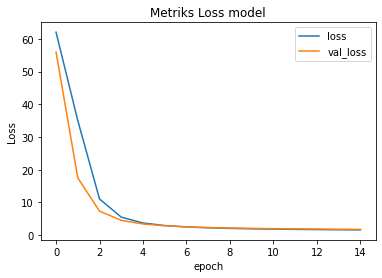

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Metriks Loss model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

## RMSE (Root Mean Squared Error)


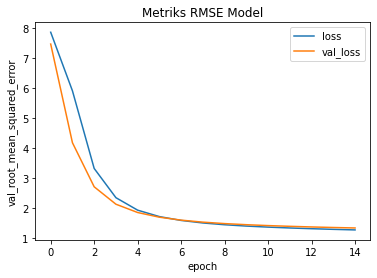

In [ ]:
plt.plot(history1.history['root_mean_squared_error'])
plt.plot(history1.history['val_root_mean_squared_error'])
plt.title('Metriks RMSE Model')
plt.ylabel('root_mean_squared_error')
plt.ylabel('val_root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

##Precision
Precision adalah rasio prediksi data benar positif dibandingkan dengan keseluruhan hasil yang diprediksi positf. Precision juga menentukan tingkat ketepatan antara informasi yang diminta oleh pengguna dengan jawaban yang diberikan oleh sistem. Pada kasus ini kita tidak bisa menghitung dengan memanggil library 'scikit learn' karena tidak terdapat data target/label seperti pada supervised learning. maka dari itu disini saya akan menghitung metrics evaluasinya secara manual dengan menggunakan rumus sebagai berikut.

Berdasarkan dari rekomendasi yang terdapat pada model cosine similarity terdapat 10/10 anime yang direkomendasikan yang memiliki genre yang relevan dengan "One Punch Man" maka metrik evaluasinya adalah 10/10 = 1. Jadi Precision dari model cosine similarity adalah 1
.

##Berdasarkan proses yang sudah dilakukan sebelumnya maka dapat disumpulkan bahwa dari pembuatan sistem rekomendasi anime dengan memanfaatkan *Content-Based Recommendation system* dan *Collaborative Filtering* maka didapatkan hasil yang sesuai seperti yang diharapkan sebelumnya, yaitu sistem dapat merekomendasikan judul anime berdasarkan genre yang relevan dan juga bedasarkan hasil review/rating penonton lain terhadap anime sekaligus dapat merekomendasikan anime terhadap sebuah user dengan prediksi yang cukup baik.